In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src')
import os
os.environ['HF_HOME'] = '/raid3/xd/.cache/torch'  # deliberately set this wrong path to avoid migrating cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="8,7"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from itertools import chain
import math
from functools import reduce, partial
from collections.abc import Iterable
from collections import namedtuple 
import traceback

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, GPT2Tokenizer#, pipeline
# from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
# from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
# from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed, AdamW

In file_utils.py: default_cache_path = /raid3/xd/.cache/torch/hub


In [4]:
sys.path.insert(0, '/nas/xd/projects/PyFunctional')
from functional import seq
from functional.pipeline import Sequence    
from fn import _ as __

In [5]:
from utils import *
from child_utils import *
from common_utils import *
from child_frames import *
from model_utils import *

In [6]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-j-6B on elderberry
proxies = {'http': '192.168.50.1:1081'} 

In [34]:
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']
gpt_model_names = ['EleutherAI/gpt-j-6B', 'EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', 'EleutherAI/gpt-neox-20b/cpu',]
#                    'KoboldAI/fairseq-dense-6.7B', 'KoboldAI/fairseq-dense-13B']
for model_name in s2s_model_names[:0] + gpt_model_names[:]:#, 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'KoboldAI/fairseq-dense-6.7B']:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        # _cache_dir = cache_dir.replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
        kwargs = dict(cache_dir=cache_dir, proxies=proxies, low_cpu_mem_usage=True)
        if 'cpu' in model_name:
            device = 'cpu'
            model = model_cls.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir, proxies=proxies)
        elif 'gpt-j' in model_name:
            device = 1
            model = model_cls.from_pretrained(model_name, revision="float16", torch_dtype=torch.float16, **kwargs).to(device)
        elif 'gpt-neox' in model_name:
            device = 0; device_map = {'gpt_neox': device, 'embed_out': device}
            model = model_cls.from_pretrained(model_name, device_map=device_map, load_in_8bit=True, **kwargs)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        # if model_name in ['EleutherAI/gpt-neox-20b']: model = model.half()
        tokenizer = AutoTokenizer.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir)
        models[model_name] = model, tokenizer#, device

EleutherAI/gpt-neox-20b/cpu ... In huggingface_hub.file_download.cached_download: url = https://huggingface.co/EleutherAI/gpt-neox-20b/resolve/main/config.json
done 0:04:33.809474


In [10]:
import openai
openai.api_key = open('/nas/xd/projects/openai_api_keys.txt').readlines()[1].split()[0]
response = openai.Completion.create(engine='text-davinci-002', prompt='Once upon a time',
    max_tokens=20, echo=True, logprobs=5)
print(response.choices[0].text)

Once upon a time

there was a little girl

who had a very special doll.

The doll


In [11]:
def get_openai_model(engine):
    def forward(input_ids):#, attention_mask=None):
        text = tokenizer.decode(input_ids[0])
        response = openai.Completion.create(engine=engine, prompt=text, max_tokens=0, echo=True, logprobs=5)
        return Outputs(logits=response.choices[0].logprobs)
    return forward
    
tokenizer0 = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
engines = ['text-babbage-001', 'text-curie-001', 'text-davinci-002']
for engine in engines: models[engine] = get_openai_model(engine), tokenizer0, None

In [17]:
models.keys()

dict_keys(['EleutherAI/gpt-j-6B', 'EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', 'EleutherAI/gpt-neox-20b/cpu', 'text-curie-001', 'text-davinci-002'])

In [8]:
def verbalize(obj):
    if type(obj) == bool: return 'Yes' if obj else 'No'
    return str(obj)
    
def make_query_str(instruction, query):
    if instruction is None and query is None: return ''
    s = '.'
    if instruction is not None: s = s + ' ' + instruction
    if query is not None:
        if type(query) in [int, bool, str]: query = [query]
        if type(query) == dict:
    #         return '. ' + '{' + ','.join([' %s: %s' % (str(k), str(v)) for k, v in query.items()]) + ' }'
            s = s + ' ' + '{' + ','.join([' replace %s with %s' % (str(k), str(v)) for k, v in query.items()]) + ' }'
        elif type(query) in [list,]:
            s = s + ' ' + ' '.join([str(i) for i in query])
    return s

def make_example_str(example, with_instruction=False):
    instruction, l, query, ans = example
    if type(ans) not in [Sequence, list]: ans = [ans]
    ans = [verbalize(a) for a in ans]
    return '%s -> %s' % (' '.join(l) + make_query_str(instruction if with_instruction else None, query), ' '.join(ans))

def sample_rand_len(vocab, k): return sample(vocab, k=randint(1, k))

In [ ]:
def p2r(p): p = seq(p); return p.zip(p.inits().zip(p.tails()))#.slice(1, p.len() - 1)
def neighbour(direction, k=1): return lambda x: x[direction][k]
def prev(k=1): return neighbour(0, k)
def next(k=1): return neighbour(1, k)
prevs, nexts = __[0][1:], __[1][1:]
beside = lambda x: (x[0][1], x[1][1])

In [ ]:
def ith_element(cxt, query): return seq(cxt).slice(1, 2)[0]
def besides(cxt, query): return seq(cxt).difference(query)[0]
# def besides_query(cxt, vocab): return cxt.a(sample, 2), cxt.list()
def get_poset(e): return tuple([p for p in posets if e in p][0])
def special(cxt, query): return seq(cxt).group_by(get_poset).map(__[1]).find(lambda x: len(x) == 1)[0]
# def special_cxt(vocab, k=3): sample(vocab[0], k - 1) + sample(vocab[1], 1)

def after_query(r, p):
    # e = r.dom().init().a(choice)
    e = choice(r.dom().init().tail().list())
    options = r.image(e).map(beside)[0].a(sample, 2)
    return e, options

def before_query(r, p):
    # e = r.dom().tail().a(choice)
    e = choice(r.dom().init().tail().list())
    options = r.image(e).map(beside)[0].a(sample, 2)
    return e, options

def after(r, q): return r.image(q).map(next())[0]
def before(r, q): return r.image(q).map(prev())[0]
def between(r, q): 
    return r.image(q[0]).map(nexts)[0].intersection(r.image(q[1]).map(prevs)[0]).union(
        r.image(q[0]).map(prevs)[0].intersection(r.image(q[1]).map(nexts)[0]))
    
def monotone_map_cxt(vocab):
    P, p = vocab
    R = p2r(P)
    E1 = R.dom().init().tail().a(choice)
    E2 = R.image(E1).map(beside)[0].a(choice)
    return R, E1, E2

def monotone_map_query(cxt, vocab):
    P, p = vocab
    r = p2r(p)
    e1 = r.dom().init().tail().a(choice)
    options = r.image(e1).map(beside)[0]
    return (r, e1), options

def monotone_map(cxt, query, reverse=False):
    R, E1, E2 = cxt
    r, e1 = query
    return r.image(e1).map(
        seq([prev(), next()]).find(lambda f: (E2 in R.image(E1).map(f)[0]) != reverse)  # reverse = not in. too tricky
    )[0]
    
tasks = [
    (ith_element, None, partial(sample, k=3), None),
    (besides, None, partial(sample, k=3), lambda cxt, vocab: (sample(cxt, 2), cxt)),
    (special, lambda: sample(posets[1:3], 2), lambda vocab: sample(sample(vocab[0], 2) + sample(vocab[1], 1), 2 + 1), None),
    
    (after, lambda: choice(closed_posets[:]), p2r, after_query, lambda r: ''),
    (before, lambda: choice(closed_posets[:]), p2r, before_query, lambda r: ''),
    (between, lambda: choice(posets), p2r, lambda r, p: r.image(r.dom().init().tail().a(choice)).map(beside)[0].a(sample, 2), lambda r: ''),
    (partial(monotone_map, reverse=False), lambda: sample(posets, 2), monotone_map_cxt, monotone_map_query),
    (partial(monotone_map, reverse=True), lambda: sample(closed_posets, 2), monotone_map_cxt, monotone_map_query),
    (lookup, )
]

In [18]:
def _str(l, vocab=None, sep=' '):
    if l is None: return ''
    if isinstance(l, str) or not isinstance(l, Iterable): l = [l]
    l = [e for e in l if not my_isinstance(e, Sequence)] #type(e).__name__ != 'Sequence']
    if isinstance(l, (dict, OrderedDict)): l = [f'{k}: {v}' for k, v in l.items()]
    return sep.join(str(i) for i in l)

def options2str(options): return '[' + ' | '.join(options) + ']'
# def options2str(options): return ' or '.join(options) + '?'

In [ ]:
# I = Identity; M = Mophism; A = Aggregation; C = CMP; G = GroupBy; l = local
patterns = ['M', 'A?', 'IA', 'MA',
    'IlI', 'MlI', 'IlM', 'MlM', 'IlMlI',
    'IlA', 'MlA', 'IlC', 'MlC', 'AlI', 'GIlI']

In [19]:
def promptize(s): return bop_str + s + eop_str
    
def make_examples(task, nrows=4, vocab_for_each_row=True, options_position=None):
    # if full_vocab is None: full_vocab = string.ascii_uppercase + string.ascii_lowercase #+ string.digits
    # transform_fn, vocab_fn, sample_fn, query_fn = task[:4]
    # if query_fn is None: query_fn = lambda *_: (None, None)
    # if vocab_fn is None: vocab_fn = lambda: full_vocab
    vocab_fn, example_gen_fn = task[:2]

    vocabs, examples = [], []
    qa_set = set() # for dedup
    if not vocab_for_each_row: vocab = vocab_fn()
    for i in range(nrows * 2):
        if vocab_for_each_row: vocab = vocab_fn()
        # cxt = sample_fn(vocab)
        # query, options = query_fn(cxt, vocab)
        # ans = transform_fn(cxt, query)
        cxt, query, candidates, ans = example_gen_fn(vocab)
        if isinstance(query, list): query = tuple(query)
        if (query, ans) not in qa_set:
            qa_set.add((query, ans))
            vocabs.append(vocab)
            examples.append([cxt, query, candidates, ans])
        if len(examples) == nrows: break
    return vocabs, examples

def make_input_str(task, vocabs, examples, options_position=None):
    task += (_str,) * (2 + 3 - len(task))
    cxt2str, query2str, ans2str = task[2:]
    def example2str(vocab, example, with_instruction=False):
        cxt, query, options, ans = example
        strs = [cxt2str(cxt, vocab), query2str(query, vocab)]
        if options_position is not None: strs.insert(options_position, options2str(options))
        return '. '.join(s for s in strs if s != '') + ' -> ' + ans2str(ans)

    text = '\n'.join(example2str(v, e) for v, e in zip(vocabs, examples)) + '\n'
    return text

In [20]:
def MlM_gen(rels, cxt_len=None):
    hop = 0
    query = choice(list(rels[hop][0].dom()))
    candidates0 = [choice(r.f(query)) for r in rels[hop][:1]]
    # candidates0 = [choice(r.f(query)) for i, r in enumerate(rels[hop]) if i == 0 or random() > 0.5] # w/ distractors
    candidates0 += sample(list(rels[hop][0].codom() - set(join_lists([r.f(query) for r in rels[hop]]))), 
        cxt_len - len(candidates0))

    hop = 1
    candidates1 = sample(list(rels[hop][0].dom()), cxt_len)
    cxt = sample(list(zip(candidates0, candidates1)), cxt_len)

    def transform_fn(cxt, query):
        hop = 0; ans = seq(cxt).find(lambda x: rels[hop][0].b(query, x[0]))[1]
        hop = 1; ans = choice(rels[hop][0].f(ans))
        return ans
    ans = transform_fn(cxt, query)
    return cxt, query, [x[1] for x in cxt], ans

def IlMlI_gen(rels, cxt_len=None):
    hop = 0
    query = choice(list(rels[hop][0].dom()))
    candidates0 = [choice(r.f(query)) for r in rels[hop][:1]]
    candidates0 += sample(list(rels[hop][0].codom() - set(join_lists([r.f(query) for r in rels[hop]]))), 
        cxt_len - len(candidates0))
    candidates0 = candidates0[:1] + sample(candidates0[1:], cxt_len - 1)

    hop = 1
    query1 = choice(list(rels[hop][0].dom()))
    candidates1 = [query1] + [choice(r.f(query1)) for r in rels[hop][:1]]
    candidates1 += sample(list(rels[hop][0].codom() - {query1} - set(join_lists([r.f(query1) for r in rels[hop]]))), 
        cxt_len - len(candidates1))
    # assert len(candidates1) == len(set(candidates1)), str(candidates1)
    cxt = sample(list(zip(candidates0, candidates1)), cxt_len)
    
    def transform_fn(cxt, query):
        hop = 0; ans = seq(cxt).find(lambda x: rels[hop][0].b(query, x[0]))[1]
        hop = 1; ans = seq(cxt).find(lambda x: x[0] != query and rels[hop][0].b(ans, x[1]))[0]
        hop = 2; ans = choice(rels[hop][0].f(ans))
        return ans
    ans = transform_fn(cxt, query)
    return cxt, query, [x[0] for x in cxt], ans

# def g2bc(g_fn, rels, cxt_len=None, labels=['T', 'F']):
#     cxt, query, candidates, ans = g_fn(rels, cxt_len=cxt_len)
#     return (cxt, choice(list(set(candidates) - {query})), labels, labels[1]) \
#         if random() > 0.5 else (cxt, query, labels, labels[0])

def g2bc(g_fn, labels=['T', 'F']):
    def wrapped(*args,**kwargs):
        cxt, query, candidates, ans = g_fn(*args,**kwargs)
        return (cxt, (query, choice(list(set(candidates) - {query, ans}))), labels, labels[1]) \
            if random() > 0.5 else (cxt, (query, ans), labels, labels[0])
    return wrapped

def _item2str(item, vocab=None): return f'{item[0]}: {item[1]}'
def lookup_item2str(item, vocab=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        if vocab[0] == clock_of_day: prep = 'at'
        elif vocab[0] == days_of_week: prep = 'on'
        elif vocab[0] == months: prep = 'in'
        return f'{item[1]} came {prep} {item[0]}'
    elif vocab[0] == digits:
        return f'{item[1]} is {item[0]}'
def _cxt2str(cxt, vocab=None, item2str=_item2str): return ', '.join([item2str(item, vocab=vocab) for item in cxt])
def _query2str(query, vocab=None): return f'{query} same as'
def lookup_query2str(query, vocab=None, rel_name=None):
    return f'just after {query}'
    if vocab[0] in [clock_of_day, days_of_week, months]:
        if vocab[0] == clock_of_day: prep = 'at'
        elif vocab[0] == days_of_week: prep = 'on'
        elif vocab[0] == months: prep = 'in'
        prep = {'prev': 'just before', 'next': 'just after', 'same': prep}[rel_name]
        return f'Who came {prep} {query}?'
    elif vocab[0] == digits:
        prep = {'prev': 'a year younger than', 'next': 'a year younger than', 'same': ''}[rel_name]
        return f'Who is {prep} {query}'
tasks = [
    # (lambda: (Poset(choice([days_of_week, months, digits, years, uppercase[:7]])), EqSet(persons)),
    (lambda: [[EqSet(persons).equal], [SymSet(frames).equal]],
        partial(MlM_gen, cxt_len=3),
        partial(_cxt2str, item2str=lambda item, vocab: f'{item[1]} {item[0]}'),
        lambda query, vocab: f'{query} is'
    ), 
    (lambda: [[EqSet(persons).equal], [PoSet(digits).equal], [EqSet(persons).equal]],
        partial(g2bc(IlMlI_gen), cxt_len=3),
        partial(_cxt2str, item2str=lambda item, vocab: f'{item[0]} {item[1]}'),
        lambda query, vocab: f'{query[0]} and {query[1]} are same?'
    ),
]

[(1, 12), (2, 10), (0, 10)]

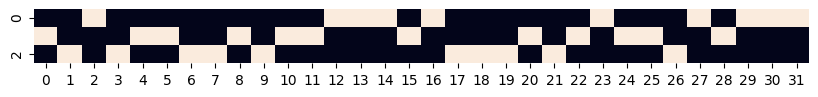

589
serious Adan, energetic Sierra, unclear Kellan. Sierra is -> energetic
old Brock, irresponsible Mila, immortal Oakleigh. Oakleigh is -> immortal
effective Ben, irregular Amaya, unpopular Raylan. Ben is -> effective
incorrect Cash, concerned Virginia, abundant Nadia. Nadia is -> abundant
illegal Celi


In [22]:
task = tasks[0]; nrows=32; k_shot=5
vocabs, _examples = make_examples(task, nrows=nrows)

answer_indices = [cands.index(ans) for _, _, cands, ans in _examples]
Counter(answer_indices).most_common()
label_probs = F.one_hot(torch.LongTensor(answer_indices))
_ = plt.figure(figsize=(10, 0.7));
_ = sns.heatmap(label_probs.T, cbar=False); plt.show()

text = make_input_str(task, vocabs, _examples)
nrows_ = nrows  #8
answer_indices_ = [cands.index(ans) for _, _, cands, ans in _examples[:nrows_]]
text_ = make_input_str(task, vocabs, _examples[:nrows_])
print(len(tokenizer.tokenize(text_))); print(text_[:300])

In [37]:
torch.cuda.empty_cache()

 ... done 0:00:00.818445


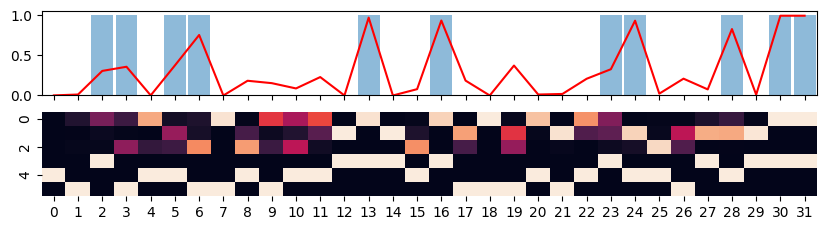

EleutherAI/gpt-j-6B 563 tensor(3.0214) 0.3333333333333333
 ... done 0:00:13.210240


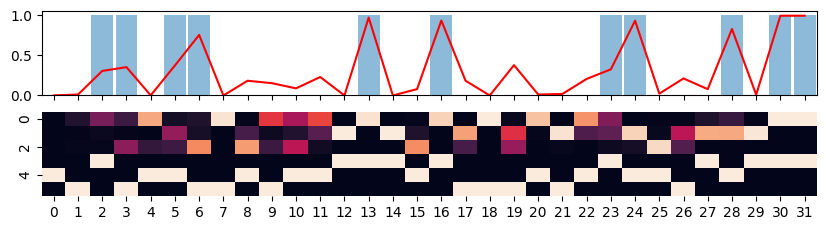

EleutherAI/gpt-j-6B/cpu 563 tensor(3.0180) 0.3333333333333333
 ... done 0:00:00.433619


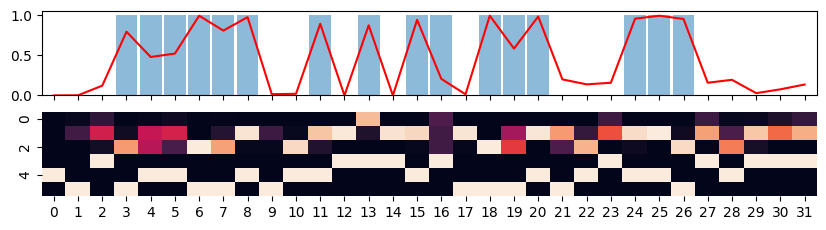

EleutherAI/gpt-neox-20b 589 tensor(1.7521) 0.5185185185185185
 ... done 0:00:39.514547


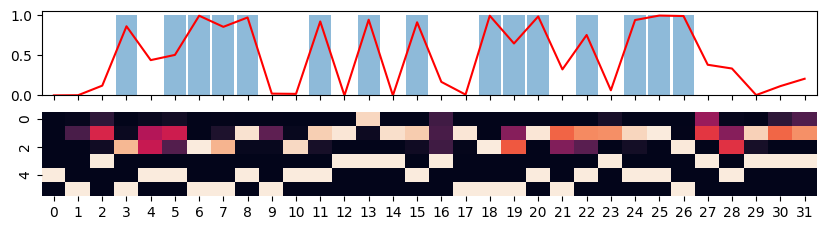

EleutherAI/gpt-neox-20b/cpu 589 tensor(1.6870) 0.5185185185185185
 ... done 0:00:01.450486


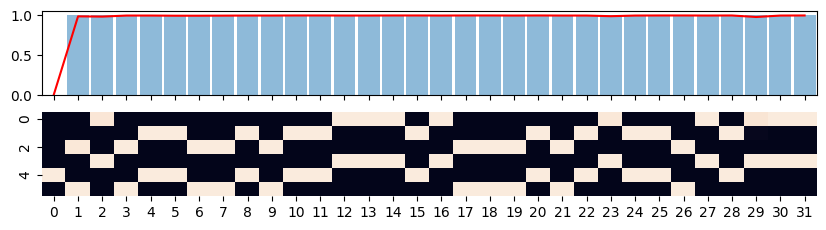

text-davinci-002 563 0.001709698279413793 1.0


In [38]:
# openai.api_key = open('/nas/xd/projects/openai_api_keys.txt').readlines()[-2].split()[0]
model_names = ['EleutherAI/gpt-j-6B', 'EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', 'EleutherAI/gpt-neox-20b/cpu', #'KoboldAI/fairseq-dense-6.7B', 'KoboldAI/fairseq-dense-13B', 
    'text-curie-001', 'text-davinci-002']#[-1:]
for model_name in gpt_model_names + engines[1:]:
    model, tokenizer, device = models[model_name]
    examples, input_ids, tokens, bos_indices, eos_indices, answers, labels = make_data_tuple(
        text if 'text' not in model_name else text_, tokenizer, k_shot=k_shot)
    candidates = [[tokenizer.encode(' ' + token)[0] for token in e[2]] for e in _examples]
    input_ids = input_ids.to(getattr(model, 'device', 'cpu'))
    with Timer():
        with torch.no_grad(): logits = model(input_ids).logits
    if isinstance(logits, torch.Tensor): logits = logits.to('cpu').float()  # softmax on cpu needs float32
        
    loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
        examples, tokenizer, logits, bos_indices, eos_indices, answers, labels,
        candidates=candidates, topk=3, verbose=len(model_names) <= 1)

    f, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 2.4), sharex=True)
    x = [i + 0.5 for i in range(nrows if 'text' not in model_name else nrows_)] # to align with sns.heatmap
    _ = ax0.bar(x, top1_corrects, width=0.9, alpha=0.5);
    _ = ax0.plot(x, answer_probs, color='r');
    label_probs = F.one_hot(torch.LongTensor(answer_indices if 'text' not in model_name else answer_indices_))
    _ = sns.heatmap(torch.cat([torch.Tensor(candidate_probs), label_probs], dim=1).T, cbar=False, ax=ax1);
    plt.show()
    print(model_name, len(tokens), loss, np.array(top1_corrects[k_shot:]).mean())

In [155]:
text = 'The capital of Canada is'
input_ids = tokenizer(text, return_tensors='pt').input_ids
list(zip(tokenizer.convert_ids_to_tokens(input_ids[0]), input_ids[0].numpy()))
outputs = model.generate(input_ids, max_length=10)
tokenizer.decode(outputs[0], skip_special_tokens=True)

[('▁The', 37),
 ('▁capital', 1784),
 ('▁of', 13),
 ('▁Canada', 1894),
 ('▁is', 19),
 ('</s>', 1)]

'Ottawa. It is the largest city in Canada'

In [478]:
# nrows = 5; k_shot = nrows // 2 + 1
# for pairs in [drop_first_and_last, ]:
nrows = 6;  k_shot = 3
for pairs in reversible_transformations + irreversible_transformations:
    seps = [' -> ', '->'] if random.random() < 0.5 else ['->', ' -> ']
    # seps = [' -> ', ' -> ']
    samples = ['\n' + '\n'.join(a + seps[0] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[0])[0])))
    samples = ['\n' + '\n'.join(b + seps[1] + a for a, b in sample(pairs, nrows)) + '\n' if pairs in reversible_transformations else 
                '\n' + '\n'.join(a + seps[1] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[1])[0])))

In [ ]:
# # sys.path.insert(0, '/nas/xd/projects/ec')
# from child_utils import loadPBETasks, retrieveJSONTasks
# challenge, challengeCheating = loadPBETasks('/nas/xd/projects/ec/PBE_Strings_Track')
# challenge2, challengeCheating2 = loadPBETasks('/nas/xd/projects/ec/data/sygus')
# tasks = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks.json")
# tasks2 = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks2.json")

In [ ]:
from lxy_utils import get_examples_behind, get_examples_before, get_examples_query_before, \
    get_examples_query_behid, get_examples_query_repeat

In [ ]:
reversible_transformations = [list(digit2cardinal.items()), noun2adj, lxy, verb_form, country2capital, en2fr, antonyms]
irreversible_transformations = [capabilities]

In [197]:
losses = []
for model_name, (model, tokenizer) in models.items():
    if any(model_name.startswith(s) for s in ['gpt2-', 'KoboldAI/fairseq-dense', 'text-davinci-001', ]): continue
    if not model_name == 'EleutherAI/gpt-j-6B': continue
    if not isinstance(model, types.FunctionType): _ = model.eval()
    with Timer(model_name): outputs = model(**inputs)
    options_ids_list = [[tokenizer.encode(' ' + option)[0] for option in options] for cxt, query, options, ans in _examples]
    mask_logits_fn = partial(mask_logits, indices=bos_indices, kept_ids=options_ids_list)
    loss, all_top1_correct = show_predictions(text, examples, tokenizer, outputs.logits, bos_indices, eos_indices, answers, labels,
                    mask_logits_fn=None, topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
    print(loss, all_top1_correct, '\n')
    losses.append(loss.item() if hasattr(loss, 'item') else loss)
    if model_name == 'EleutherAI/gpt-j-6B': break
print(sum(losses) / len(losses))

EleutherAI/gpt-j-6B ... done 0:00:01
* C 0.842 {' C': 0.842, ' A': 0.041, ' B': 0.04} 	 D -> C
* Thursday 0.778 {' Thursday': 0.778, ' Wednesday': 0.064, ' Friday': 0.063} 	 Friday -> Thursday
* a 0.742 {' a': 0.742, ' c': 0.051, ' A': 0.036} 	 b -> a
* four 0.472 {' four': 0.472, ' three': 0.246, ' one': 0.105} 	 five -> four
tensor(0.3677, grad_fn=<NllLossBackward>) True 

0.3677041530609131


In [24]:
relational_functions = [prev(), next()]
rel_fns = [prevs, nexts]

**TODO: read children books for more posets**  
**TODO: Prompt gpt3 to elicit the posets it knows**  
$x \to f(x)$ where $f \in \{\text{prev/next in posets of numbers/letters/months/days, antonym, hypernym, hyponym, ...}\}$  
$x \to f^2(x)$  
one poset or mixed posets  
$x, f(x).~y \to Ff^{[-1]}(y)$ one poset or mixed posets  
$x, f^k(x).~y \to Ff^{[-1]}(y)~/Ff^{[-]k}(y)$  
$x, f(f(x))~/f(f(x)), x \to f(x)$ in between, the simplest form of sequence completion  
$x, f(x) \to Gf$ where $Gf \in \{<, >\}$  
$x, f(x); y, g(y) \to Ff \stackrel{?}{=} g^{[-1]}$ where $\text{output} \in \{\text{True}, \text{False}\}$  
sort

There is a *natural* monotone map/functor $F$ between posets/sets $A$ and $B$.  Compose the computation (set operations, sorting etc.) between $A$ and $B$ with $F$ to make harder tasks.  
$P(A) ,P(B) \to F(P(A)) \setminus ~/ \cap ~/ \triangle P(B)$. Harder form of set difference/intersection.  
$P(A) \to F(\text{sorted}(P(A)))$. Harder form of sorting.


In [385]:
n_total, n_valid = 192, 64
n_train = n_total - n_valid

input_strs = [make_input_str(tasks[4], nrows=4, ncols=5) for __ in range(n_total)]
for s in sample(input_strs, 3): print(s)

Instruction: replace with the other. For example:
G H G G G -> H G H H H
I I I I M -> M M M M I
A A F A A -> F F A F F
9 9 9 I I -> I I I 9 9

Instruction: replace with the other. For example:
V Q Q V V -> Q V V Q Q
G L L G L -> L G G L G
G 2 2 2 G -> 2 G G G 2
I I Z Z Z -> Z Z I I I

Instruction: replace with the other. For example:
R H H H R -> H R R R H
B 9 9 B B -> 9 B B 9 9
D 2 2 2 D -> 2 D D D 2
A A A A W -> W W W W A



In [368]:
sum(s.count('Yes') for s in input_strs)

370

In [322]:
train_dataset = CHILDDataset(input_strs[:-n_valid], tokenizer)
eval_dataset = CHILDDataset(input_strs[-n_valid:], tokenizer)

In [121]:
if n_total == 1:
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    inputs = prepare_inputs(inputs, model.device)
    outputs = model(**inputs, output_attentions=False)

    # assert inputs.input_ids.size(0) == 1
    input_ids = inputs.input_ids
    logits = outputs.logits

    bsz = input_ids.size(0); assert bsz == 1
    labels = torch.ones_like(input_ids) * (-100)
    for bi in range(bsz):
        bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
        eos_indices = (input_ids[bi] == eos_id).nonzero()[-nrows:].squeeze(1)
        for i, (example, bos_i, eos_i) in enumerate(zip(examples, bos_indices.tolist(), eos_indices.tolist())):
            print(' ' + make_example_str(example))
            ans_ids = input_ids[bi, bos_i + 1: eos_i]
            if i >= 2: labels[bi, bos_i: eos_i - 1] = ans_ids
            ans_prob_dist = logits[bi, bos_i: eos_i - 1].softmax(-1)
            ans_probs = ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids]
            ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
            for ans_id, ans_token, ans_prob, dist in zip(ans_ids, ans_tokens, numpy(ans_probs, decimals=3), ans_prob_dist):
                top1_correct = (dist.argmax() == ans_id).item()
                print(('*' if top1_correct else ' ') + ans_token, ans_prob, 
                      show_topk(*dist.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)) 
    loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))
    loss

In [329]:
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=16, per_device_eval_batch_size=16,
    weight_decay=0.01, adam_beta2=0.98, adam_epsilon=1e-6,
    lr_scheduler_type='constant', learning_rate=5e-3, num_train_epochs=4,
    logging_strategy ='epoch', evaluation_strategy ='epoch', save_steps=0,
    no_cuda=True, report_to='none',  # to avoid report to wandb
)

In [330]:
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,
                  optimizers=(create_optimizer(model, training_args), None))

In [333]:
trainer.place_model_on_device

True

In [ ]:
def get_prev(elem):
    i, v = elem
    return _l[i - 1] if i > 0 else None

false = lambda *_: False
true  = lambda *_: True

In [ ]:
Element = namedtuple('Element', 'index value')
_l = 'A B C B'.split()
n = len(_l)
# l = [Element._make(e) for e in enumerate(l)]
l = seq(_l)
l = l.enumerate().map(Element._make)

In [6]:
l.map(lambda x: {'B': 'D'}.get(x, x))

l.filter(lambda x: get_prev(x) == 'B').select(_.value)

find_fn = _.index == 1
l.filter(find_fn).select(_.value).map(lower)

find_fn = _.value == 'C'
l.filter(find_fn).select(_.index)

# move x to first
update_filter = _.value == 'C'
get_new = lambda x: -1
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# swap first and last
update_filter = true
get_new = lambda x: {0: n - 1, n - 1: 0}.get(x.index, x.index)
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# get inbetween == drop_while + take_while?

# update by index to its prev
update_filter = _.index == 1
get_new = lambda x: get_prev(x)
def update_fn(x, update_field): return get_new(x) if update_filter(x) else getattr(x, update_field)
l.map(lambda x: Element(x.index, update_fn(x, 'value')))

# if two adjacent elements by indices are equal
l.filter(lambda x: x.index in [0, 1]).select(_.value).distinct().len() == 1

seq('A B C B C'.split()).group_by(_).select(_[1]).flatten()

# count occurance till current
seq('A B A C B A'.split()).inits().reverse().tail().map(lambda x: x.filter(_ == x.last()).len())

# find special
seq('A B A A'.split()).count_by_value().filter(_[1] == 1).select(_[0])

# generalized find special
seq('A A B C C D D'.split()).group_by(_).map(lambda x: (x[0], len(x[1]))).filter(_[1] == 1).select(_[0])